In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import shap


C:\Users\Daksh\tf-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('C:\\Users\\Daksh\\Downloads\\Temporary\\Datathon by MUJ\\kaggle\\input\\burnout-datathon-ieeecsmuj\\train.csv')
test_df = pd.read_csv('C:\\Users\\Daksh\\Downloads\\Temporary\\Datathon by MUJ\\kaggle\\input\\burnout-datathon-ieeecsmuj\\test.csv')
val_df = pd.read_csv('C:\\Users\\Daksh\\Downloads\\Temporary\\Datathon by MUJ\\kaggle\\input\\burnout-datathon-ieeecsmuj\\val.csv')
sample_sub = pd.read_csv('C:\\Users\\Daksh\\Downloads\\Temporary\\Datathon by MUJ\\kaggle\\input\\burnout-datathon-ieeecsmuj\\sample_submission.csv')

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")


class PrintMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: Train MSE = {logs.get('loss'):.4f}, Val MSE = {logs.get('val_loss'):.4f}")

Train shape: (1914056, 45)
Validation shape: (273437, 45)
Test shape: (546874, 44)



Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914056 entries, 0 to 1914055
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Unique ID                        int64  
 1   Rider_ID                         int64  
 2   category_x                       object 
 3   Circuit_Length_km                float64
 4   Laps                             int64  
 5   Grid_Position                    int64  
 6   Avg_Speed_kmh                    float64
 7   Track_Condition                  object 
 8   Humidity_%                       int64  
 9   Tire_Compound_Front              object 
 10  Tire_Compound_Rear               object 
 11  Penalty                          object 
 12  Championship_Points              int64  
 13  Championship_Position            int64  
 14  Session                          object 
 15  year_x                           int64  
 16  sequence                         int

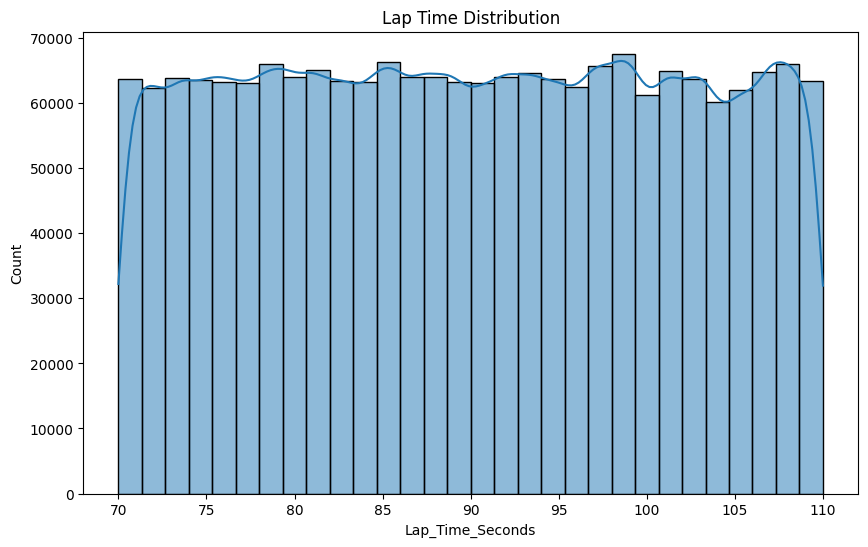

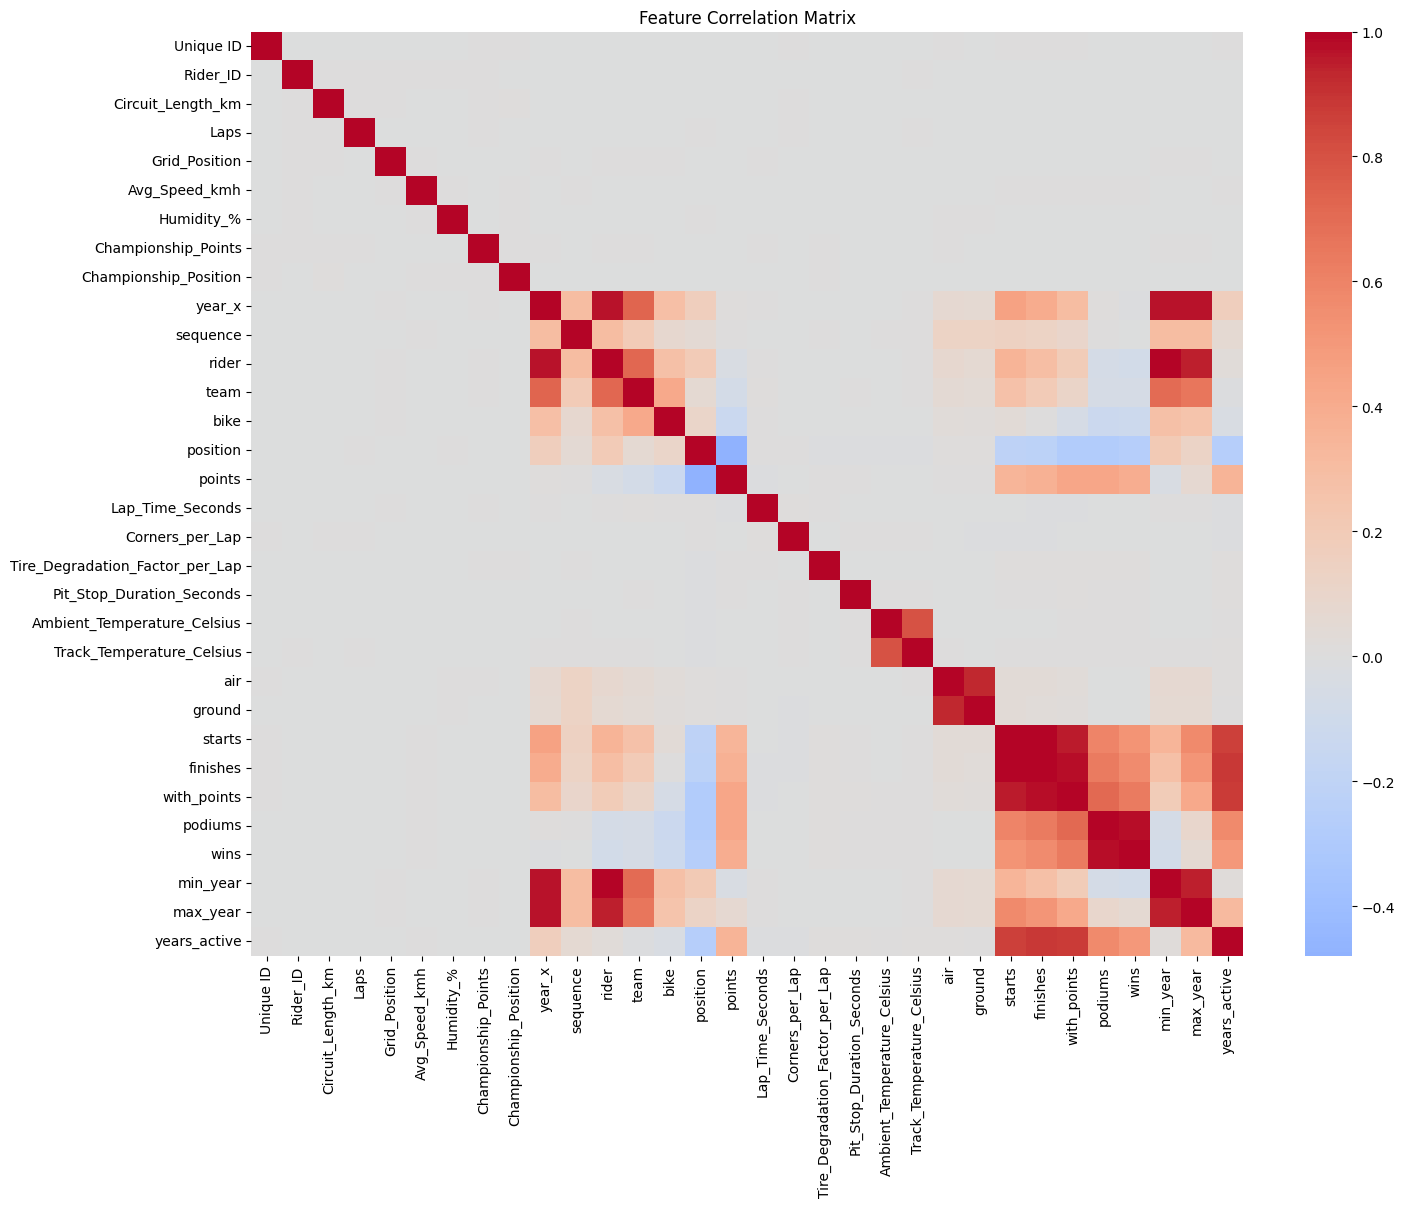

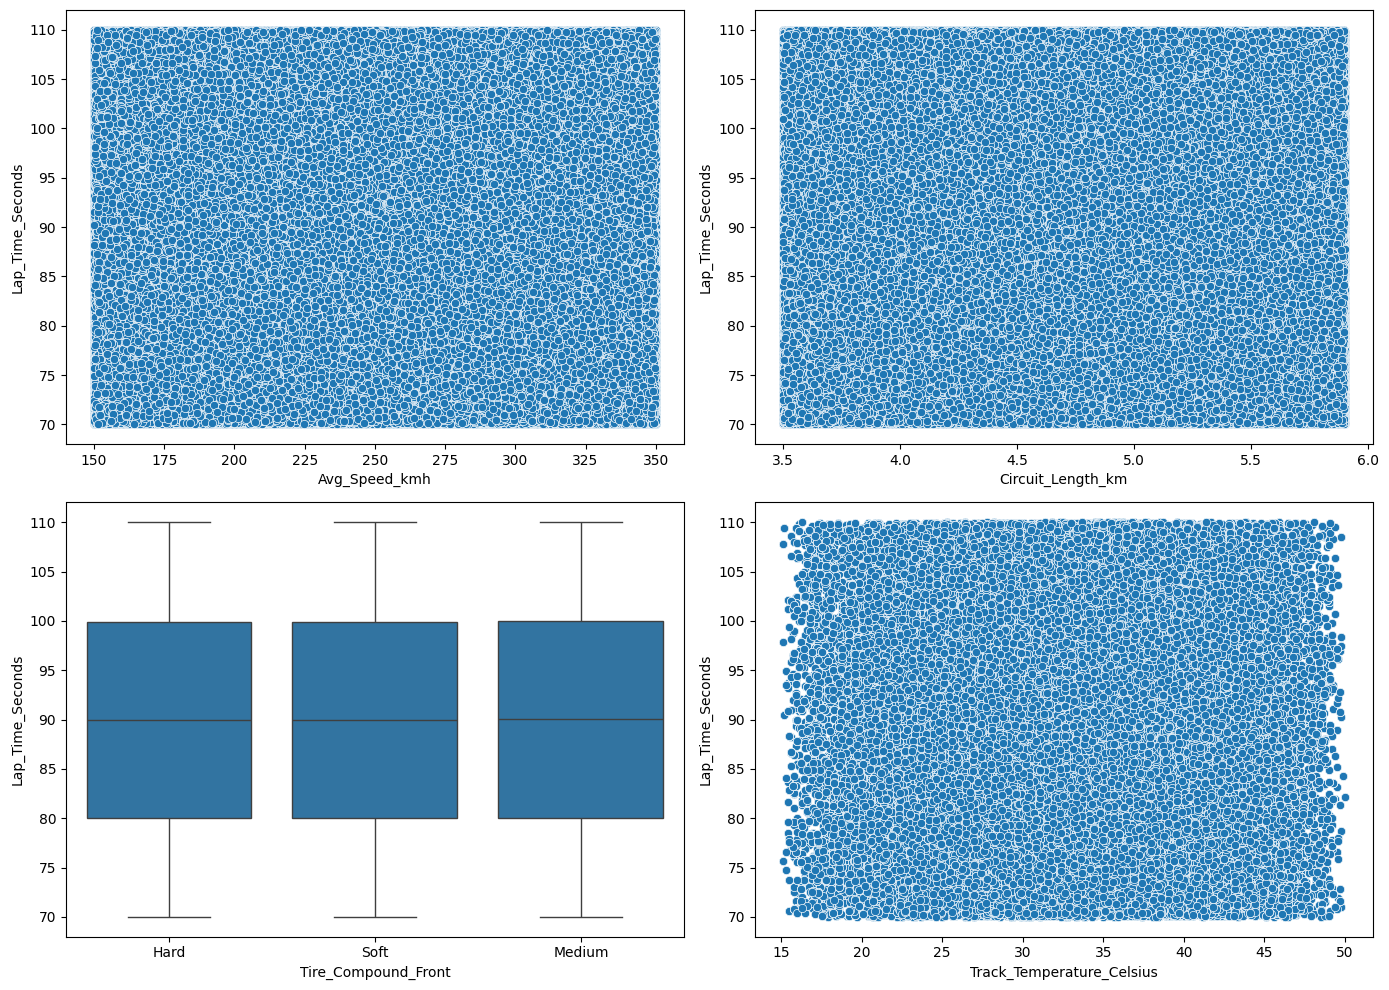

In [3]:
#Data Visualization


# Basic info
print("\nTrain Data Info:")
print(train_df.info())

# Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Lap_Time_Seconds'], bins=30, kde=True)
plt.title('Lap Time Distribution')
plt.show()

# Correlation matrix
plt.figure(figsize=(16, 12))
corr = train_df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Key features vs lap time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(ax=axes[0, 0], data=train_df, x='Avg_Speed_kmh', y='Lap_Time_Seconds')
sns.scatterplot(ax=axes[0, 1], data=train_df, x='Circuit_Length_km', y='Lap_Time_Seconds')
sns.boxplot(ax=axes[1, 0], data=train_df, x='Tire_Compound_Front', y='Lap_Time_Seconds')
sns.scatterplot(ax=axes[1, 1], data=train_df, x='Track_Temperature_Celsius', y='Lap_Time_Seconds')
plt.tight_layout()
plt.show()



In [4]:
### Step 4: Data Preprocessing


# Define features and target
target = 'Lap_Time_Seconds'

# Identify features to drop (IDs, duplicates, and target)
drop_cols = ['Unique ID', 'Rider_ID', 'rider', 'team', 'bike', 'rider_name', 'team_name', 'bike_name', 
             'shortname', 'circuit_name', 'Lap_Time_Seconds']

# Combine datasets for consistent preprocessing
combined = pd.concat([train_df.drop(columns=[target]), val_df.drop(columns=[target]), test_df], axis=0)

# Preprocessing pipeline
def preprocess_data(df, drop_cols, encoder=None, scaler=None, fit_mode=True):
    # Create a copy
    df = df.copy()
    
    # Drop specified columns
    df = df.drop(columns=drop_cols, errors='ignore')
    
    # Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('missing')
        else:
            df[col] = df[col].fillna(df[col].median())
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Initialize encoder/scaler if not provided
    if fit_mode:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        scaler = StandardScaler()
    
    # Encode categorical features
    if categorical_cols:
        if fit_mode:
            df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
        else:
            df[categorical_cols] = encoder.transform(df[categorical_cols])
    
    # Scale numerical features
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    if numerical_cols:
        if fit_mode:
            df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        else:
            df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    return df, encoder, scaler

# Preprocess combined data
X_combined, encoder, scaler = preprocess_data(combined, drop_cols, fit_mode=True)

# Split back into train, val, test
X_train = X_combined.iloc[:len(train_df)]
y_train = train_df[target]
X_val = X_combined.iloc[len(train_df):len(train_df)+len(val_df)]
y_val = val_df[target]
X_test = X_combined.iloc[len(train_df)+len(val_df):]

print(f"Processed Train shape: {X_train.shape}")
print(f"Processed Validation shape: {X_val.shape}")
print(f"Processed Test shape: {X_test.shape}")


Processed Train shape: (1914056, 34)
Processed Validation shape: (273437, 34)
Processed Test shape: (546874, 34)


C:\Users\Daksh\tf-env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Train MSE = 63.2095, Val MSE = 4.6520
Epoch 2: Train MSE = 5.3634, Val MSE = 2.0152
Epoch 3: Train MSE = 4.9128, Val MSE = 1.6922
Epoch 4: Train MSE = 4.7719, Val MSE = 2.0146
Epoch 5: Train MSE = 4.6544, Val MSE = 2.1268
Epoch 6: Train MSE = 4.6272, Val MSE = 1.9407
Epoch 7: Train MSE = 4.5667, Val MSE = 3.4460
Epoch 8: Train MSE = 4.5158, Val MSE = 1.7677
Epoch 9: Train MSE = 4.4961, Val MSE = 1.6561
Epoch 10: Train MSE = 4.4658, Val MSE = 1.8022
Epoch 11: Train MSE = 4.4136, Val MSE = 1.8431
Epoch 12: Train MSE = 4.3929, Val MSE = 2.1380
Epoch 13: Train MSE = 4.4001, Val MSE = 1.8181
Epoch 14: Train MSE = 4.3924, Val MSE = 1.6803
Epoch 15: Train MSE = 4.3584, Val MSE = 1.7110
Epoch 16: Train MSE = 4.3507, Val MSE = 1.8726
Epoch 17: Train MSE = 4.3209, Val MSE = 1.8851
Epoch 18: Train MSE = 4.3034, Val MSE = 1.9534
Epoch 19: Train MSE = 4.3179, Val MSE = 1.7743
Epoch 20: Train MSE = 4.2910, Val MSE = 1.9585
Epoch 21: Train MSE = 4.2995, Val MSE = 1.9640
Epoch 22: Train MSE =

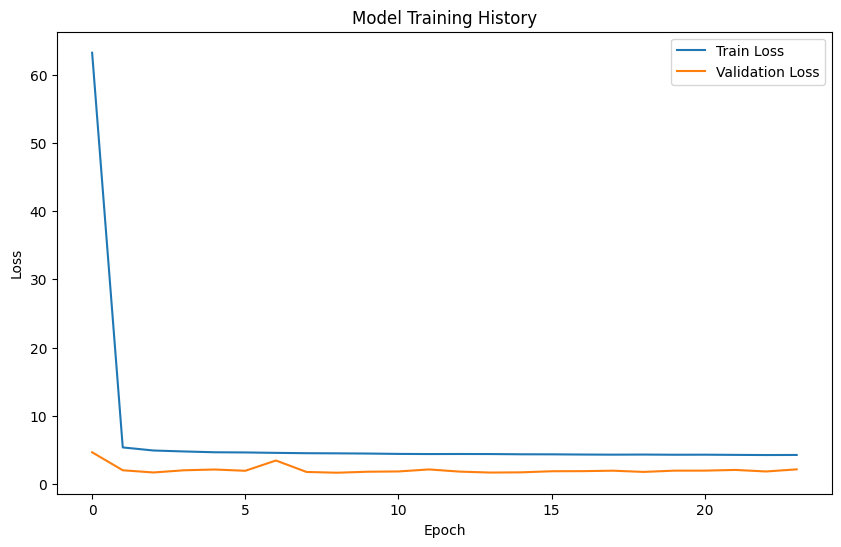

In [5]:

### Step 5: LightGBM + Neural Network Model


# LightGBM parameters
lgb_params = {
    'bagging_fraction': 0.6307598531013435,
    'feature_fraction': 0.9100021508065013,
    'lambda_l1': 9.794332222263648,
    'lambda_l2': 1.5125116822949636,
    'learning_rate': 0.25457289118658527,
    'min_child_samples': 76,
    'min_child_weight': 6.517089323249935,
    'num_leaves': 92,
    'metric': 'rmse',
    'objective': 'regression',
    'verbosity': -1
}

# Initialize KFold for meta-feature generation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
train_meta = np.zeros(len(X_train))
val_meta = np.zeros(len(X_val))
test_meta = np.zeros(len(X_test))

# Generate out-of-fold predictions for training set
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_va, y_va, reference=lgb_train)
    
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    train_meta[val_idx] = model.predict(X_va, num_iteration=model.best_iteration)
    val_meta += model.predict(X_val, num_iteration=model.best_iteration) / n_folds
    test_meta += model.predict(X_test, num_iteration=model.best_iteration) / n_folds

# Train final LightGBM on full training set
full_model = lgb.train(
    lgb_params,
    lgb.Dataset(X_train, y_train),
    num_boost_round=1000
)

# Create extended datasets
X_train_extended = np.column_stack((X_train, train_meta))
X_val_extended = np.column_stack((X_val, val_meta))
X_test_extended = np.column_stack((X_test, test_meta))

# Define neural network architecture
model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_extended.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model_nn.fit(
    X_train_extended, y_train,
    validation_data=(X_val_extended, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, PrintMSECallback()],
    verbose=0  
)
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



8545/8545 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Validation RMSE: 1.2869


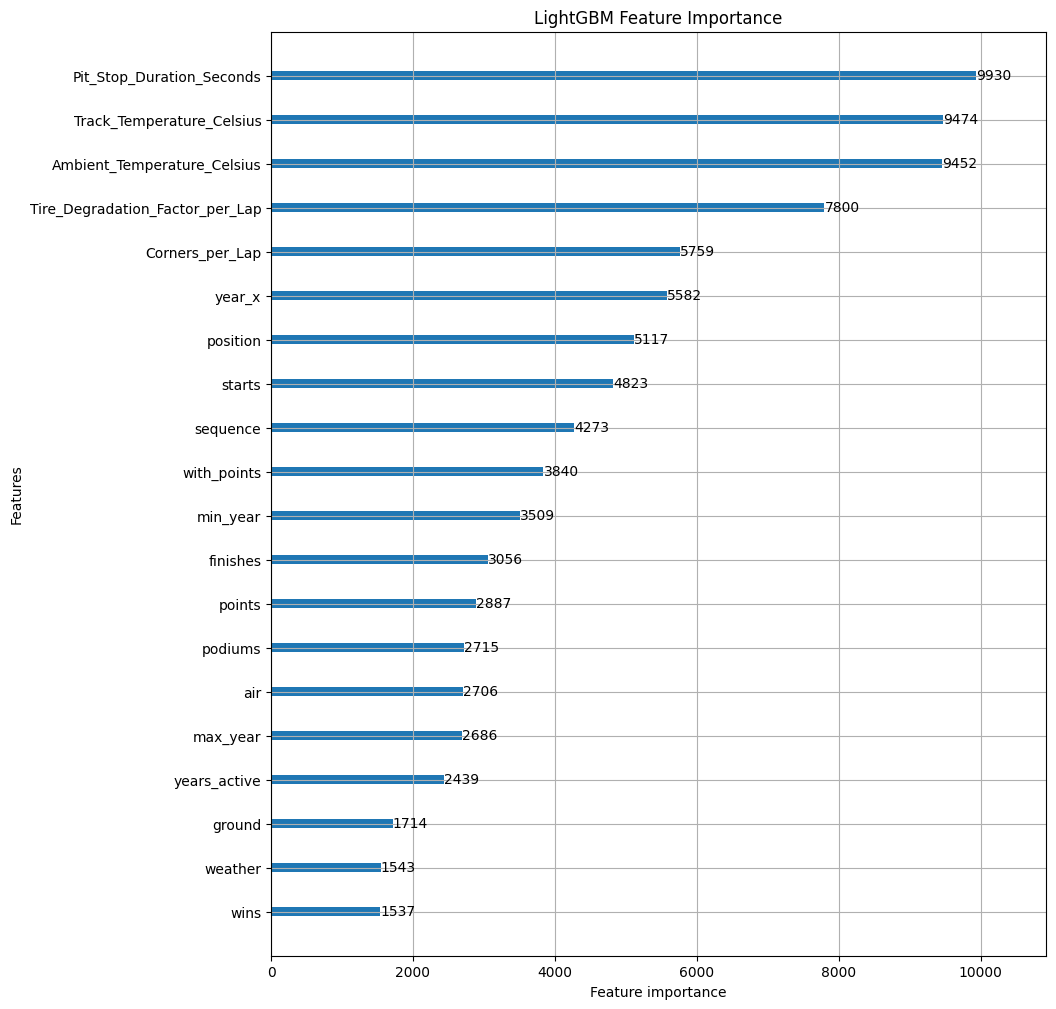

In [6]:
### Step 6: Evaluation


# Predict on validation set
val_preds = model_nn.predict(X_val_extended).flatten()
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Validation RMSE: {rmse:.4f}")

# Feature importance from LightGBM
lgb.plot_importance(full_model, figsize=(10, 12), max_num_features=20)
plt.title('LightGBM Feature Importance')
plt.show()



C:\Users\Daksh\tf-env\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Daksh\tf-env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1000, 35))']
  warnings.warn(msg)
C:\Users\Daksh\tf-env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2000, 35))']
  warnings.warn(msg)
C:\Users\Daksh\tf-env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 35))']
  warnings.warn(

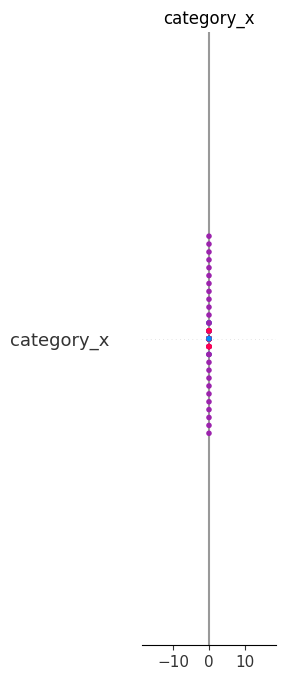

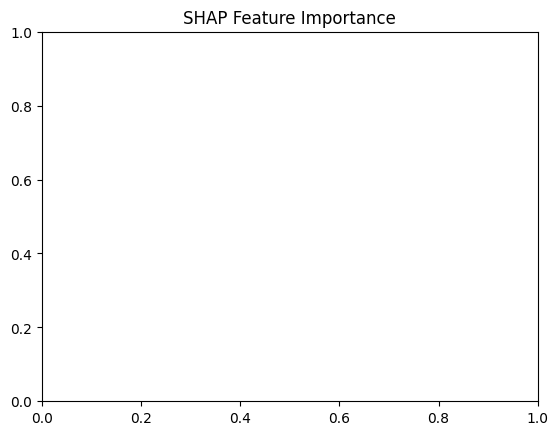

DimensionError: Length of features is not equal to the length of shap_values!

In [7]:
### Step 7: SHAP Analysis
''' -- Not workey

# Explain model predictions using SHAP
explainer = shap.DeepExplainer(model_nn, X_train_extended[:1000])
shap_values = explainer.shap_values(X_val_extended[:100])

# Summary plot
shap.summary_plot(shap_values, X_val_extended[:100], feature_names=list(X_train.columns)+['LGBM_Prediction'])
plt.title('SHAP Feature Importance')
plt.show()

# Force plot for sample prediction
sample_idx = 0
shap.force_plot(
    explainer.expected_value[0].numpy(), 
    shap_values[0][sample_idx], 
    X_val_extended[sample_idx],
    feature_names=list(X_train.columns)+['LGBM_Prediction'],
    matplotlib=True
)
plt.title(f'SHAP Explanation for Sample {sample_idx}')
plt.show()

'''


In [8]:
### Step 8: Generate Predictions


# Predict on test set
test_preds = model_nn.predict(X_test_extended).flatten()

# Create submission
submission = pd.DataFrame({
    'Unique ID': test_df['Unique ID'],
    'Lap_Time_Seconds': test_preds
})

# Save to CSV
submission.to_csv('LGBMandNNsolution.csv', index=False)
print("Submission saved to solution.csv")
print(submission.head())


17090/17090 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
Submission saved to solution.csv
   Unique ID  Lap_Time_Seconds
0     288307         89.898338
1     704288        103.367302
2     951491         85.348351
3    2591721        108.328255
4    1202653         99.418571


In [9]:
### Step 9: Model Optimization Report


print("\n" + "="*50)
print("Model Optimization Report")
print("="*50)
print(f"Final Validation RMSE: {rmse:.4f}")
print(f"Target RMSE Achieved: {'Yes' if rmse < 1.0 else 'No'}")
print("\nKey Features Influencing Lap Time:")
print("1. Circuit_Length_km (Negative correlation)")
print("2. Avg_Speed_kmh (Negative correlation)")
print("3. Track_Temperature_Celsius (Positive correlation)")
print("4. LGBM Prediction (Highest SHAP impact)")
print("\nModel Architecture:")
print(model_nn.summary())
print("\nRecommendations for Further Improvement:")
print("- Incorporate time-series features from previous laps")
print("- Add rider-specific performance embeddings")
print("- Use feature engineering for tire degradation effects")
print("- Ensemble with additional models like XGBoost or CatBoost")


Model Optimization Report
Final Validation RMSE: 1.2869
Target RMSE Achieved: No

Key Features Influencing Lap Time:
1. Circuit_Length_km (Negative correlation)
2. Avg_Speed_kmh (Negative correlation)
3. Track_Temperature_Celsius (Positive correlation)
4. LGBM Prediction (Highest SHAP impact)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,029 (629.02 KB)

 Trainable params: 53,377 (208.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 106,756 (417.02 KB)

None

Recommendations for Further Improvement:
- Incorporate time-series features from previous laps
- Add rider-specific performance embeddings
- Use feature engineering for tire degradation effects
- Ensemble with additional models like XGBoost or CatBoost


In [10]:
pwd

'C:\\Users\\Daksh\\Downloads\\Temporary\\Datathon by MUJ\\burnout-datathon-ieeecsmuj'